## Test of the RINN model on a linear ODE

This notebook is an implementation of the RINN integration scheme given a known linear ODE, it can be used mostly to evaluate the stability of the learnt integration scheme

In [1]:
import sys
sys.path.append('/homes/s17ouala/Bureau/Sanssauvegarde/Complement/RINN/LearningODEIntegrationSchemes')
from generate_data import generate_data
import numpy as np
from scipy.integrate import odeint
from dynamical_models import Lorenz_63, Lorenz_96, oregonator, Adv_Dif_1D
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from utils import RMSE
from tqdm import tqdm
import sympy as sp

In [2]:
# generating training data
class GD:
    model = 'Adv_Dif_1D_Real'
    class parameters:
        w = -2
        x0 = 0.5
        t0 = 0
    dt_integration =0.01# integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8# number of integration times between consecutive observations (for yo)
    var_obs = np.array([0]) # indices of the observed variables
    nb_loop_train = 10.1 # size of the catalog
    nb_loop_test = 100 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 2.0 # variance of the observation error to generate observation
    
# run the data generation
catalog, xt, yo = generate_data(GD)
#training data
batch_size = catalog.true_solution[:-10-1,:].shape[0]
X_train    = np.reshape(catalog.true_solution[:-10-1,:],(int(catalog.true_solution[1:-10,:].shape[0]/batch_size),batch_size,catalog.true_solution[1:-10,:].shape[1]))
Grad_t     = np.reshape(np.gradient(catalog.true_solution[:-10-1,0])/GD.dt_integration,(X_train.shape))
Y_train    = np.reshape(catalog.true_solution[1:-10,:],(int(catalog.true_solution[1:-10,:].shape[0]/batch_size),batch_size,catalog.true_solution[1:-10,:].shape[1]))

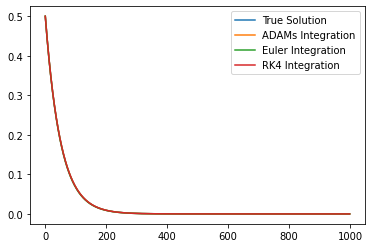

In [3]:
plt.plot(catalog.true_solution[:1000],label = 'True Solution')
plt.plot(catalog.num_integration[:1000],label = 'ADAMs Integration')
plt.plot(catalog.euler_integration[:1000],label = 'Euler Integration')
plt.plot(catalog.RK4_integration[:1000],label = 'RK4 Integration')

plt.legend()

In [4]:
#NN parameters 
params = {}
params['lin_coef']= GD.parameters.w
params['dim_input']=1
params['dim_output']=1
params['dim_observations']=1
params['dt_integration']=GD.dt_integration
params['ntrain']=[40000,0,0]
params['order'] = 4
pretrained = False
path = None#'Lin_w=-05.pt'
order= 4#number of stages of the runge kutta scheme

In [5]:
np.random.seed(0)
torch.manual_seed(0)
class FC_net_lin(torch.nn.Module):
        def __init__(self, params):
            super(FC_net_lin, self).__init__()
            self.coef_mdl =params['lin_coef']
        def forward(self, inp):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            grad = self.coef_mdl*inp
            return grad
model =  FC_net_lin(params)
class INT_net(torch.nn.Module):
        def __init__(self, params):
            super(INT_net, self).__init__()
            a = 0.*np.tril(np.random.uniform(size=(1,order,order)),k=-1)
            b = 0.*np.random.uniform(size=(1,order))
            c = 0.01*np.random.uniform(size=(1,order))
            self.a = torch.nn.Parameter(torch.from_numpy(a).double())
            self.b = torch.nn.Parameter(torch.from_numpy(b).double())
            self.c = torch.nn.Parameter(torch.from_numpy(c).double())
            self.Dyn_net = model
        def forward(self, inp, dt, order):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k = [(self.Dyn_net(inp))]
            for i in range(1,order):
                coef_sum = torch.zeros(k[0].size())
                for j in range(0,i):
                    if j ==0:
                        if i == 1:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                        else:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                    else :
                        coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                rk_inp = inp+dt*coef_sum        
                k.append(self.Dyn_net(rk_inp))
            pred_sum = torch.zeros(k[0].size())
            for i in range(0,order): 
                pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
            pred = inp +dt*pred_sum
            gain = pred[0,:]/(inp[0,:])
            return pred ,k[0], gain 
class applyRK_Constraints(object):
        def __init__(self, frequency=1):
            self.frequency = frequency
    
        def __call__(self, module):
            if hasattr(module, 'b'):
                module.b.data = (torch.abs(module.b.data))
                module.b.data  =  ((module.b.data) / (module.b.data).sum(1,keepdim = True).expand_as(module.b.data))
            if hasattr(module, 'c'):
                module.c.data = module.c.data
                module.c.data[:,0] = 0
                module.c.data = module.c.data.sub_(torch.min(module.c.data)).div_(torch.max(module.c.data) - torch.min(module.c.data)).sort()[0]


# learning the 4 stage RK integration scheme

In [6]:
x = (torch.from_numpy(X_train).double())
y = (torch.from_numpy(Y_train).double())
z = (torch.from_numpy(Grad_t).double())
if pretrained :
    modelRINN.load_state_dict(torch.load(path))
modelRINN = INT_net(params)
criterion = torch.nn.MSELoss(reduction = 'elementwise_mean')
optimizer = torch.optim.Adam(modelRINN.parameters(), lr  = 0.01)
clipper   = applyRK_Constraints()

In [ ]:
print ('Learning dynamical model')
for t in range(params['ntrain'][0]):
        for b in range(x.shape[0]):
            # Forward pass: Compute predicted gradients by passing x to the model
            pred ,grad , inp = modelRINN(x[b,:,:],params['dt_integration'],params['order'])
            pred2 ,grad , inp = modelRINN(pred,params['dt_integration'],params['order'])
            pred3 ,grad , inp = modelRINN(pred2,params['dt_integration'],params['order'])
            pred4 ,grad , inp = modelRINN(pred3,params['dt_integration'],params['order'])
            # Compute and print loss
            loss = criterion(pred, y[b,:,:])+criterion(pred2[:-1,:], pred[1:,:])+criterion(pred3[:-1,:], pred2[1:,:])+criterion(pred4[:-1,:], pred3[1:,:])
            print(t,loss)
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            modelRINN.apply(clipper)

# Test

In [8]:
#forecasting 
tmp = np.reshape(-0.5,(1,1))
nb_steps_pred = 2000
t_pred = nb_steps_pred * GD.dt_integration
y_pred=np.zeros((nb_steps_pred,params['dim_output']))
tmp = np.reshape(-0.5,(1,1))
tmp = (torch.from_numpy(tmp).float())
y_pred[:1,:] = tmp
for i in range(1,nb_steps_pred):
    y_pred[i,:] = modelRINN(tmp,params['dt_integration'],order)[0].data.numpy()
    tmp = (torch.from_numpy(np.reshape(y_pred[i,:] ,(1,params['dim_output']))).double())

In [9]:
# computing RK4 and Euler of new initial condition
# generating training data
class GD:
    model = 'Adv_Dif_1D_Real'
    class parameters:
        w = -2
        x0 = -0.5
        t0 = 0
    dt_integration =0.01# integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8# number of integration times between consecutive observations (for yo)
    var_obs = np.array([0]) # indices of the observed variables
    nb_loop_train = 10.1 # size of the catalog
    nb_loop_test = 100 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 2.0 # variance of the observation error to generate observation
    
# run the data generation
catalog, xt, yo = generate_data(GD)

RMSE true solution vs RK4 :  7.578855549338177e-11
RMSE true solution vs Euler :  0.0005623115404097864
RMSE true solution vs RINN  :  1.2222117835284356e-14


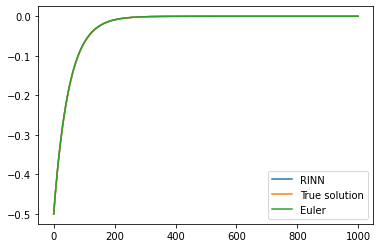

In [10]:
test_dt = 1
dt_ratio = int(test_dt/GD.dt_integration)
length_pred = 1000
plt.plot(y_pred[:length_pred],label = 'RINN')
plt.plot(catalog.true_solution[:length_pred],label = 'True solution')
plt.plot(catalog.euler_integration[:length_pred],label = 'Euler')
plt.legend()
print('RMSE true solution vs RK4 : ', RMSE(catalog.true_solution[:length_pred],catalog.RK4_integration[:length_pred]))
print('RMSE true solution vs Euler : ', RMSE(catalog.true_solution[:length_pred],catalog.euler_integration[:length_pred]))
print('RMSE true solution vs RINN  : ', RMSE(catalog.true_solution[:length_pred],y_pred[:length_pred]))

In [11]:
# computing error time series 
error_Euler = []
error_RK4   = []
error_ADRK  = []

len_error_series = length_pred
for i in range(1,len_error_series+1):
    error_RK4.append(RMSE(catalog.true_solution[:i],catalog.RK4_integration[:i]))
    error_Euler.append(RMSE(catalog.true_solution[:i],catalog.euler_integration[:i]))
    error_ADRK.append(RMSE(catalog.true_solution[:i],y_pred[:i]))
error_Euler = np.array(error_Euler)
error_RK4   = np.array(error_RK4)
error_ADRK  = np.array(error_ADRK)

In [12]:
time = np.arange(len_error_series)*GD.dt_integration

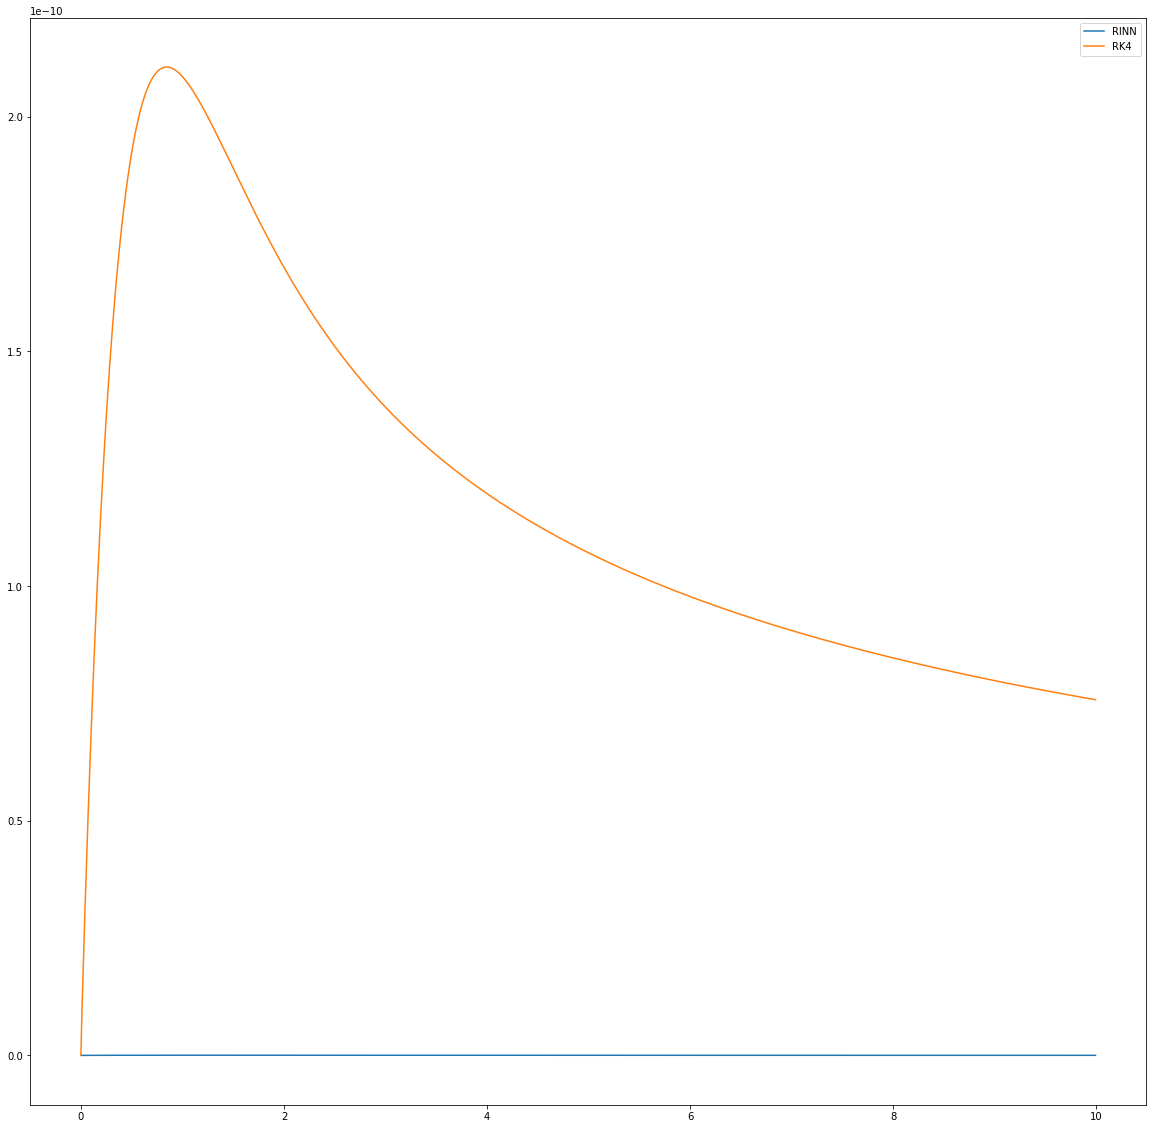

In [13]:
plt.figure(figsize=(20,20))
#plt.plot(np.arange(len_error_series)*GD.dt_integration,error_Euler,label = 'Euler')
plt.plot(np.arange(len_error_series)*GD.dt_integration,error_ADRK,label = 'RINN')
plt.plot(np.arange(len_error_series)*GD.dt_integration,error_RK4,label = 'RK4')
plt.legend()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


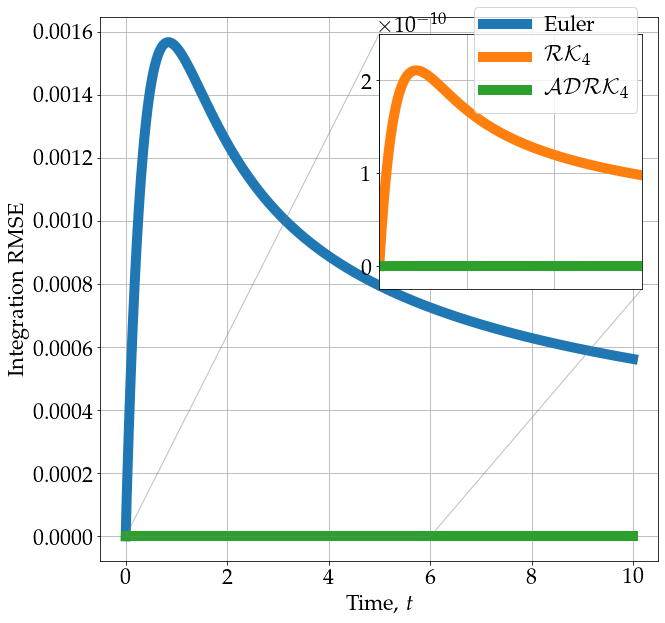

In [14]:
import matplotlib as mpl
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
end_plt = len_error_series
fig, ax = plt.subplots(figsize=[10, 10])
ax.plot(time,error_Euler,label = 'Euler',lw = 10)
ax.plot(time,error_RK4,label = '$\mathcal{RK}_4$',lw = 10)
ax.plot(time,error_ADRK,label = '$\mathcal{ADRK}_4$',lw = 10)
ax.legend(bbox_to_anchor=(0.65, 1.04), loc='upper left')
ax.set_xlabel('Time, $t$')
ax.set_ylabel('Integration RMSE')
#ax.tick_params(left=False,
#                bottom=False,
#                labelleft=False,
#                labelbottom=False)
# inset axes....
axins = ax.inset_axes([0.5, 0.5, 0.47, 0.47])
axins.plot(time,error_Euler,label = 'Euler',lw = 2)
axins.plot(time,error_RK4,label = '$\mathcal{RK}_4$',lw = 10)
axins.plot(time,error_ADRK,label = '$\mathcal{ADRK}_4$',lw = 10)

# sub region of the original image
x1, x2, y1, y2 = 0.0, 6, -2.5E-11, 2.5E-10
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
#axins.set_xticklabels('')
#axins.set_yticklabels('')
axins.grid()
axins.tick_params(left=True,
                bottom=False,
                labelleft=True,
                labelbottom=False)
ax.indicate_inset_zoom(axins)
ax.grid()

# Stability analysis of the integration scheme with respect to Euler and RK4 schemes : 

We need first to write the integration scheme as $x_{t+1} = G(h) x{t}$ where $G$ is the gain matrix (here scalar since we are working in 1D).

if G<1  : the integration scheme is stable 
if G=>1 : the integration scheme is unstable
G = 1 when the integration time step = 0

In [15]:
#extracting integration scheme params
a=modelRINN.a.clone().data.numpy()
b=modelRINN.b.clone().data.numpy()
c=modelRINN.c.clone().data.numpy()
xt, h = sp.symbols('xt h')

In [16]:
# computing analytic form of the integration scheme
k = [(modelRINN.Dyn_net.forward(xt))]
for i in range(1,order):
    coef_sum = 0
    for j in range(0,i):
        if j ==0:
            if i == 1:
                coef_sum = coef_sum + k[j]*(c[:,i])
            else:
                coef_sum = coef_sum + k[j]*(c[:,i]-a[:,i,1:i].sum(1))
        else :
            coef_sum = coef_sum + k[j]*a[:,i,j]
    rk_inp = xt+h*coef_sum        
    k.append((modelRINN.Dyn_net.forward(rk_inp)))
#            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()).double())
pred_sum = 0   
for i in range(0,order): 
    pred_sum = pred_sum+k[i]*b[:,i]
    xt_1 = xt +h*pred_sum
# extracting the gain factor
g = xt_1.factor(xt)/xt

In [17]:
# RK4 analytic integration scheme
grad = modelRINN.Dyn_net.forward(xt)
k1   = modelRINN.Dyn_net.forward(xt)
k2   = modelRINN.Dyn_net.forward(xt+0.5*h*k1)
k3   = modelRINN.Dyn_net.forward(xt+0.5*h*k2)
k4   = modelRINN.Dyn_net.forward(xt+h*k3)            
xt_1RK4 = xt +h*(k1+2*k2+2*k3+k4)/6

gRK4 = xt_1RK4.factor(xt)/xt

In [18]:
xt, h = sp.symbols('xt h')
l = GD.parameters.w
# RK4 analytic integration scheme
grad = l*xt
k1   = l*xt
k2   = l*(xt+0.5*h*k1)
k3   = l*(xt+0.5*h*k2)
k4   = l*(xt+h*k3)            
xt_1RK42 = xt +h*(k1+2*k2+2*k3+k4)/6

gRK42 = xt_1RK42.factor(xt)/xt

In [19]:
gRK42

0.666666666666667*h**4 - 1.33333333333333*h**3 + 2.0*h**2 - 2.0*h + 1.0

In [20]:
g

1.98241426705447e-5*h**4 - 0.0304284650014402*h**3 + 1.9870373502635*h**2 - 2.0*h + 1.0

In [21]:
# stability graph
hi = np.arange(0,64+0.000001,GD.dt_integration)
gainRK4 = np.zeros_like(hi)
for i in range(len(hi)):
    gainRK4[i] = np.abs(gRK4.evalf(subs={h: hi[i]}))
gainE = np.zeros_like(hi)
for i in range(len(hi)):
    gainE[i] = np.abs(1-np.abs(GD.parameters.w)*hi[i])
gain = np.zeros_like(hi)
for i in range(len(hi)):
    gain[i] = np.abs(g.evalf(subs={h: hi[i]}))

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


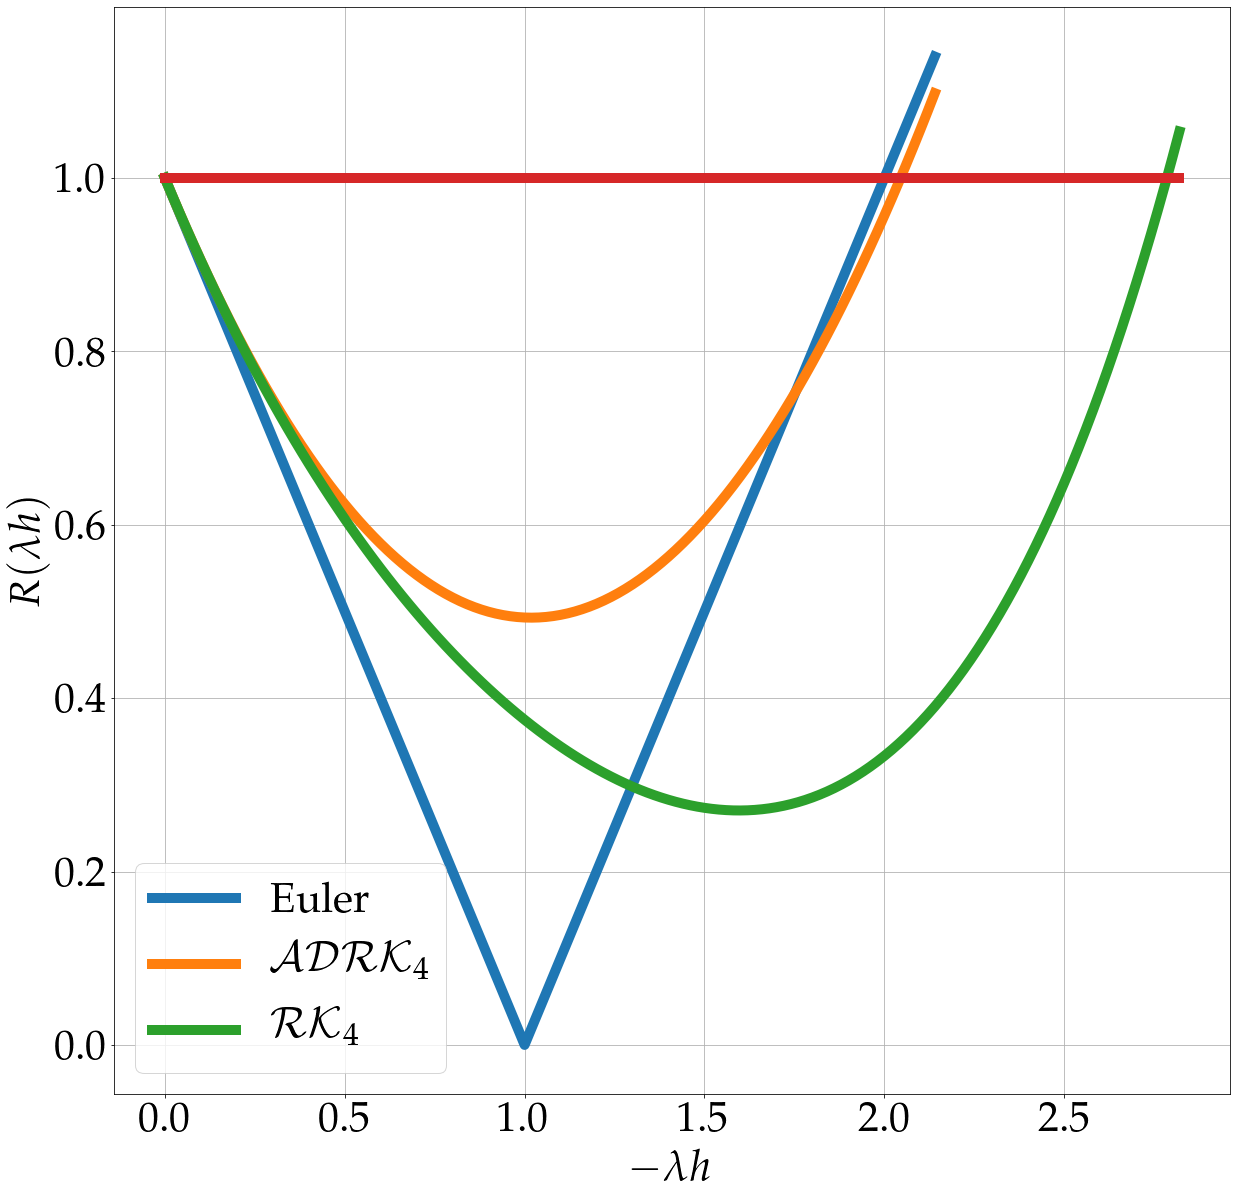

In [22]:
length_h = 108
length_h_RK4 = 142

plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.figure(figsize=(20,20))
plt.plot(hi[:length_h]*np.abs(GD.parameters.w),gainE[:length_h],label = 'Euler',lw = 10)
plt.plot(hi[:length_h]*np.abs(GD.parameters.w),gain[:length_h],label = '$\mathcal{ADRK}_4$',lw = 10)
plt.plot(hi[:length_h_RK4]*np.abs(GD.parameters.w),gainRK4[:length_h_RK4],label = '$\mathcal{RK}_4$',lw = 10)
plt.plot(hi[:length_h_RK4]*np.abs(GD.parameters.w),np.ones_like(gainRK4[:length_h_RK4]),lw = 10)
#plt.plot(hi[:600],np.abs(ff[-1].data.numpy()[:600]))
plt.xlabel('$-\lambda h$')
plt.ylabel('$R(\lambda h)$')
plt.grid()
plt.legend()

# Testing the Trained Integration scheme on the Non-Linear 96 equation

In [23]:
# Lorenz 63 and 96 classes
class FC_net_true(torch.nn.Module):
        def __init__(self, params):
            super(FC_net_true, self).__init__()
        def forward(self, inp):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            arg = [10.0, 28.0, 8.0/3]
            grad = Variable(torch.zeros((inp.size())))
            grad[:,0] = arg[0]*(inp[:,1]-inp[:,0]);
            grad[:,1] = inp[:,0]*(arg[1]-inp[:,2])-inp[:,1];
            grad[:,2] = inp[:,0]*inp[:,1] - arg[2]*inp[:,2];
#            dS  = np.array([x_1,x_2,x_3]);
#            grad = self.outputLayer(aug_vect)
            return grad
model_true  = FC_net_true(params)

class FC_net_true_L96(torch.nn.Module):
        def __init__(self, params):
            super(FC_net_true_L96, self).__init__()
        def forward(self, S):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            J = 40
            F = 8
            x = torch.zeros(S.shape[0],J);
            x[:,0] = (S[:,1]-S[:,J-2])*S[:,J-1]-S[:,0];
            x[:,1] = (S[:,2]-S[:,J-1])*S[:,0]-S[:,1];
            x[:,J-1] = (S[:,0]-S[:,J-3])*S[:,J-2]-S[:,J-1];
            for j in range(2,J-1):
                x[:,j] = (S[:,j+1]-S[:,j-2])*S[:,j-1]-S[:,j];
            dS = x + F;
            return dS
model_true_L96  = FC_net_true_L96(params)

In [24]:
# Global class with both the Lorenz 63 and 96 models, implemented with the RK45 and the RINN integration schemes
class INT_net_NL(torch.nn.Module):
        def __init__(self):
            super(INT_net_NL, self).__init__()
            a = 0.*np.tril(np.random.uniform(size=(1,order,order)),k=-1)
            b = 0.*np.random.uniform(size=(1,order))
            c = 0.01*np.random.uniform(size=(1,order))
            self.a = modelRINN.a
            self.b = modelRINN.b
            self.c = modelRINN.c
            self.Dyn_net_L96 = model_true_L96
            self.Dyn_net_L63 = model_true

        def flow_RINN_True_Model_L96(self, inp, dt, order):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k = [(self.Dyn_net_L96(inp))]
            for i in range(1,order):
                coef_sum = torch.zeros(k[0].size())
                for j in range(0,i):
                    if j ==0:
                        if i == 1:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                        else:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                    else :
                        coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                rk_inp = inp+dt*coef_sum        
                k.append(self.Dyn_net_L96(rk_inp))
            pred_sum = torch.zeros(k[0].size())
            for i in range(0,order): 
                pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
            pred = inp +dt*pred_sum
            gain = pred[0,:]/(inp[0,:])
            return pred ,k[0], gain 
        def flow_RINN_True_Model_L63(self, inp, dt, order):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k = [(self.Dyn_net_L63(inp))]
            for i in range(1,order):
                coef_sum = torch.zeros(k[0].size())
                for j in range(0,i):
                    if j ==0:
                        if i == 1:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                        else:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                    else :
                        coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                rk_inp = inp+dt*coef_sum        
                k.append(self.Dyn_net_L63(rk_inp))
            pred_sum = torch.zeros(k[0].size())
            for i in range(0,order): 
                pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
            pred = inp +dt*pred_sum
            gain = pred[0,:]/(inp[0,:])
            return pred ,k[0], gain 
        def flow_RK45_True_Model_L96(self, inp,dt,order = 4):
            k1    = self.Dyn_net_L96(inp)
            inp_k2 = inp + 0.5*dt*k1
            k2  = self.Dyn_net_L96(inp_k2)
            inp_k3 = inp + 0.5*dt*k2       
            k3   = self.Dyn_net_L96(inp_k3)
            inp_k4 = inp + dt*k3          
            k4   = self.Dyn_net_L96(inp_k4)            
            pred = inp +dt*(k1+2*k2+2*k3+k4)/6    
            return pred, k1    
        def flow_RK45_L63(self, inp,dt,order = 4):
            k1    = self.Dyn_net_L63(inp)
            inp_k2 = inp + 0.5*dt*k1
            k2  = self.Dyn_net_L63(inp_k2)
            inp_k3 = inp + 0.5*dt*k2       
            k3   = self.Dyn_net_L63(inp_k3)
            inp_k4 = inp + dt*k3          
            k4   = self.Dyn_net_L63(inp_k4)            
            pred = inp +dt*(k1+2*k2+2*k3+k4)/6    
            return pred, k1        
modelRINN_NL = INT_net_NL()

In [25]:
nb_steps_pred = 400
t_pred = nb_steps_pred * GD.dt_integration
y_pred=np.zeros((nb_steps_pred,40))
tmp = np.ones((1,40))#np.reshape(catalog.analogs[0,:],(1,params['dim_output']))
tmp[0,20:] = 1+0.01
tmp = Variable(torch.from_numpy(tmp).float())

for i in range(nb_steps_pred):
    y_pred[i,:] = modelRINN_NL.flow_RINN_True_Model_L96(tmp,0.05,order)[0].data.numpy()
    tmp = Variable(torch.from_numpy(np.reshape(y_pred[i,:] ,(1,40))).float())

<Figure size 360x360 with 0 Axes>

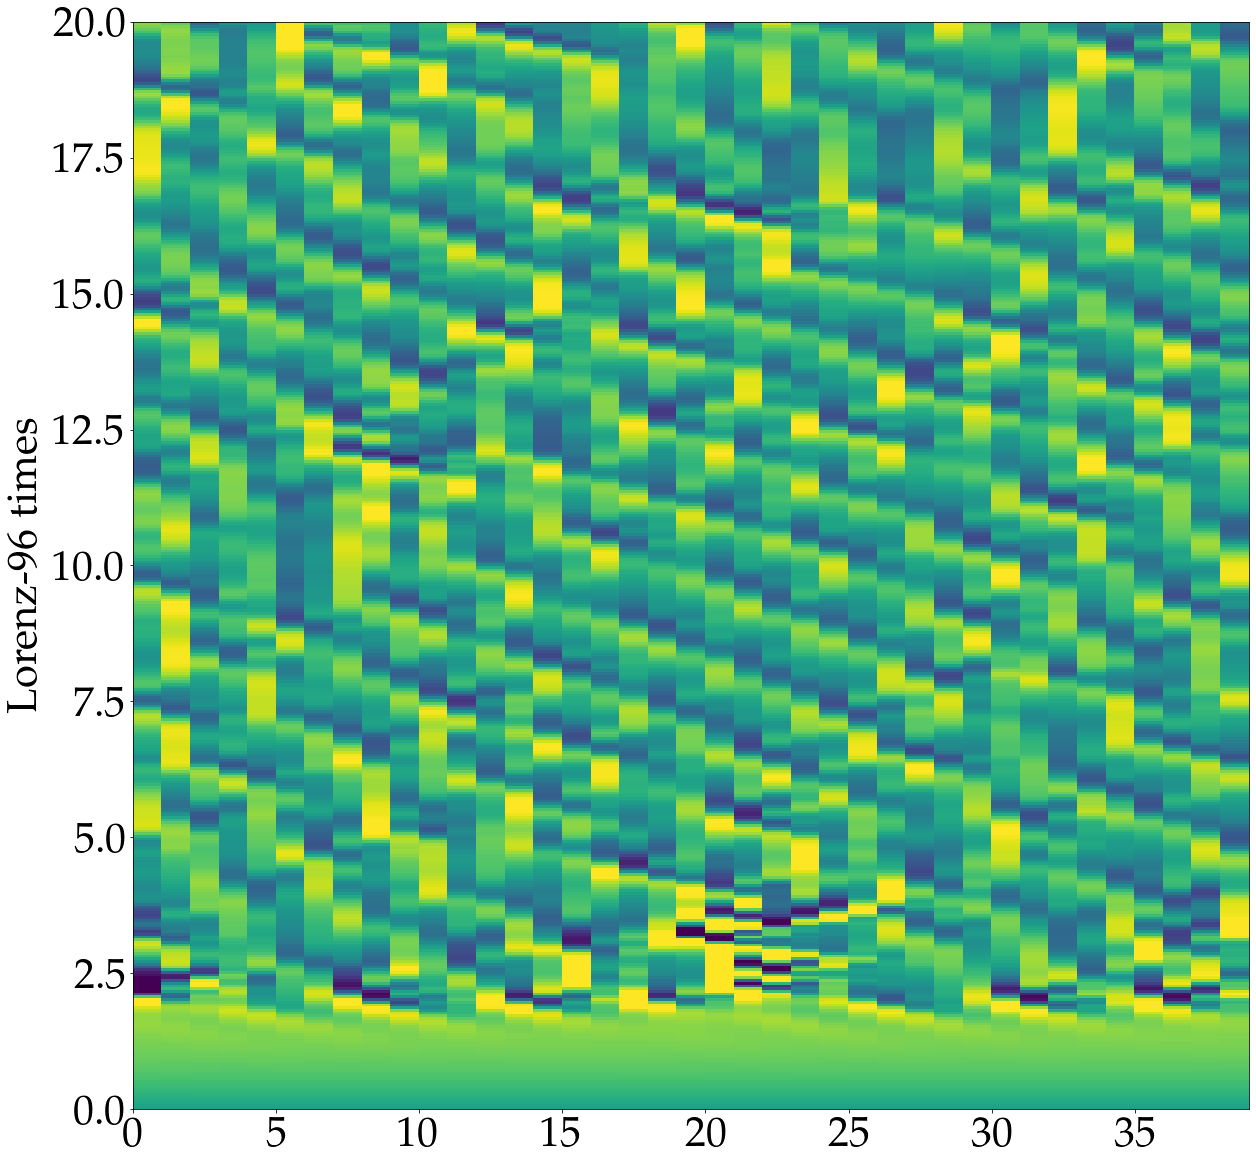

In [26]:
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.figure(figsize=(5,5))
[X,Y]= np.meshgrid(range(40),np.linspace(0,nb_steps_pred*0.05,nb_steps_pred+1))
plt.figure(figsize=(20,20))
plt.pcolor(X,Y,y_pred);
plt.xlim([0,40-1]);
plt.clim([-10,10]);
plt.ylabel('Lorenz-96 times');

# Testing the Trained Integration scheme on the Non-Linear 63 equation

In [27]:
nb_steps_pred =20000
t_pred = nb_steps_pred * GD.dt_integration
y_pred_L63=np.zeros((nb_steps_pred,3))
tmp = np.ones((1,3))#np.reshape(catalog.analogs[0,:],(1,params['dim_output']))
tmp = Variable(torch.from_numpy(tmp).float())

for i in tqdm(range(nb_steps_pred)):
    y_pred_L63[i,:] = modelRINN_NL.flow_RINN_True_Model_L63(tmp,0.01,order)[0].data.numpy()
    tmp = Variable(torch.from_numpy(np.reshape(y_pred_L63[i,:] ,(1,3))).float())

100%|██████████| 20000/20000 [00:14<00:00, 1368.52it/s]


Text(0.5, 0, '$z_3$')

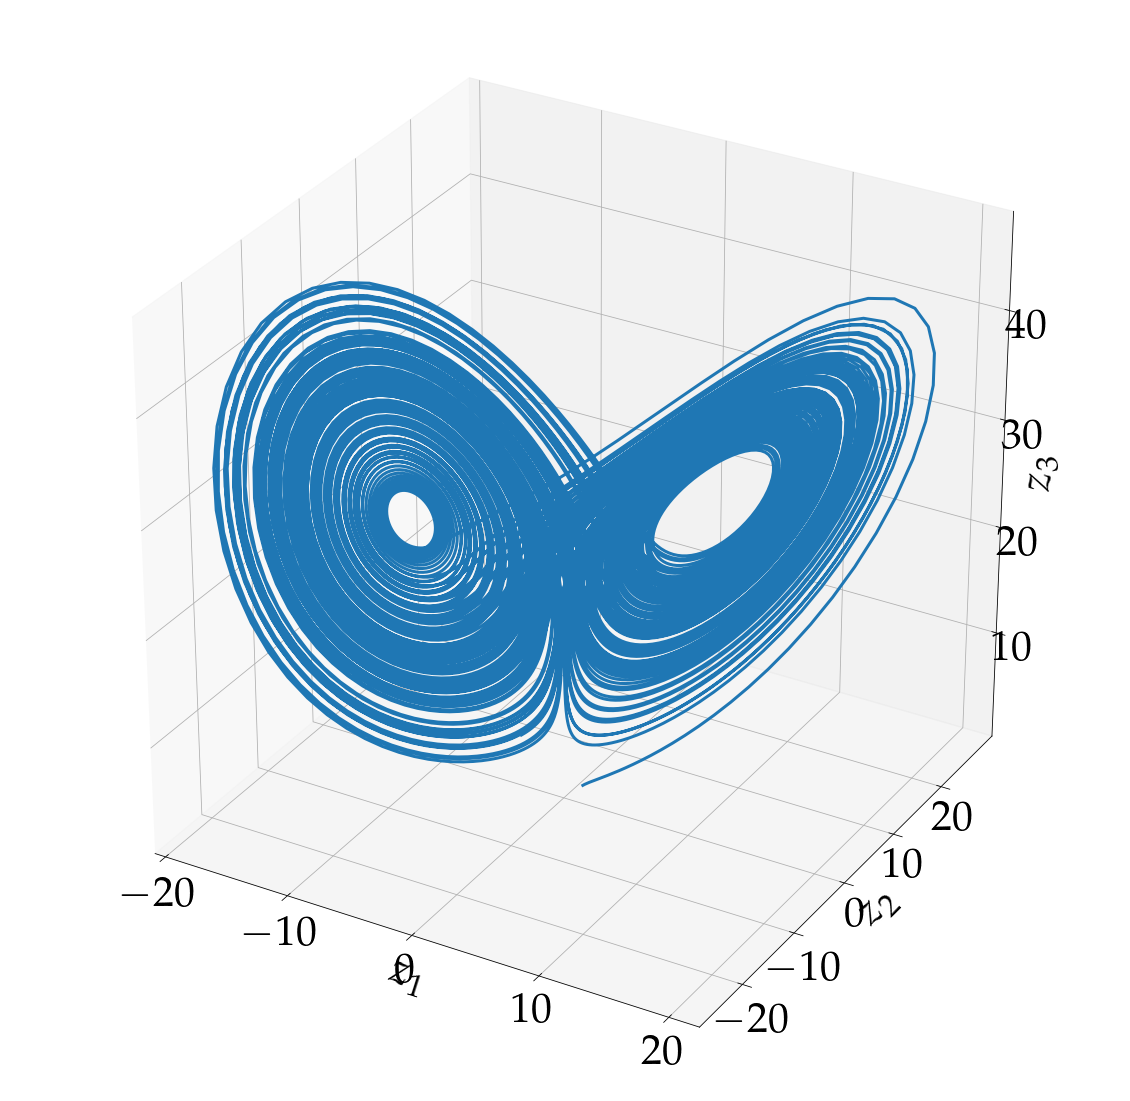

In [28]:
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
fig = plt.figure(figsize=(20,20))
ax=fig.gca(projection='3d')
line1,=ax.plot(y_pred_L63[:,0],y_pred_L63[:,1],y_pred_L63[:,2],lw = 3)
ax.set_xlabel('$z_1$',labelpad = 11);ax.set_ylabel('$z_2$',labelpad = 11);ax.set_zlabel('$z_3$',labelpad = 11)